![alt text](https://drive.google.com/uc?export=view&id=1UXScsVx_Wni_JuDdB8LeTnM6jsPfIwkW)

<span style="font-family: Arial; font-weight:bold;font-size:2em;color:#00b3e5;"> Computer Vision Project 2  Part A
    
<span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#00b3e5;"> Submitted by
    
<span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#00b3e5;"> Shameer.Sutar


<span style="font-family: Arial; font-weight:bold;font-size:2em;color:#00b3e5;">Part A
    

• DOMAIN: Entertainment

• CONTEXT: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis.Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and multimedia experts who need to detect faces from screen shots from the movie scene.The data labelling is already done. Since there higher time complexity is involved in the 

• DATA DESCRIPTION: The dataset comprises of images and its mask for      corresponding human face.

• PROJECT OBJECTIVE: To build a face detection system.

In [2]:
import tensorflow
tensorflow.__version__

'2.11.0'

In [3]:
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

### change to working directory

In [5]:
import os

os.chdir('C:\\Users\ADMIN')
print('Working directory changed!')

#verifying the current working directory
cwd = os.getcwd()
print('Current working directory: ', cwd)
import warnings
warnings.filterwarnings("ignore")

Working directory changed!
Current working directory:  C:\Users\ADMIN


### Load the "images.npy" file
- This file contains images with details of bounding boxes

In [6]:
import numpy as np
df = np.load('images.npy', allow_pickle = True)

### Check one sample from the loaded "images.npy" file 


In [7]:
print (df[0][1])

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063}, {'x': 0.1723076923076923, 'y': 0.45345345345345345}], 'imageWidth': 650, 'imageHeight': 333}, {'label': ['Face'], 'notes': '', 'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913}, {'x': 0.6584615384615384, 'y': 0.46846846846846846}], 'imageWidth': 650, 'imageHeight': 333}]


### Set image dimensions 
- Initialize image height, image width with value: 224 

In [8]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

### Create features and labels

In [10]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(df.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(df.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(df.shape[0]):
    img = df[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in df[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Split the data into training and testing 
- 400 images in training
- 9 images in testing data

#### Training data

In [11]:
X_train = X[:400]
y_train = masks[:400]

#### Testing data

In [13]:
X_test = X[400:]
y_test = masks[400:]

### Select random image from the train data and display original image and masked image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[ 0.45882356  0.47450984  0.57647061]
  [ 0.45882356  0.47450984  0.57647061]
  [ 0.4666667   0.48235297  0.58431375]
  ...
  [-0.72549021 -0.49803919 -0.16862744]
  [-0.75686276 -0.48235291 -0.30196077]
  [-0.74117649 -0.47450978 -0.27843136]]

 [[ 0.49803925  0.52941179  0.62352943]
  [ 0.49803925  0.52941179  0.62352943]
  [ 0.52941179  0.56078434  0.65490198]
  ...
  [-0.74901962 -0.52156866 -0.21568626]
  [-0.65490198 -0.38823527 -0.17647058]
  [-0.67058825 -0.40392154 -0.18431371]]

 [[ 0.44313729  0.47450984  0.56862748]
  [ 0.35686278  0.38823533  0.48235297]
  [ 0.41960788  0.45098042  0.54509807]
  ...
  [-0.65490198 -0.41960782 -0.13725489]
  [-0.84313726 -0.58431375 -0.32549018]
  [-0.85882354 -0.60000002 -0.34117645]]

 ...

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [

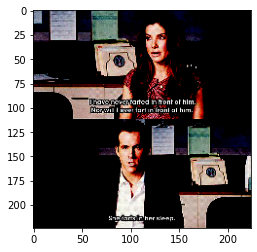

In [17]:
import matplotlib.pyplot as plt
print (X_train[5])
plt.imshow (X_train[5])

Print the mask

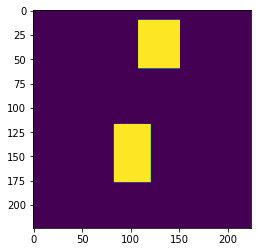

In [18]:
plt.imshow (y_train[5])

## Create the model 
- Use MobileNet as model Base
- Add UNET architecture layers

In [19]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D
from tensorflow.keras.models import Model

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
  
    block0 = model.get_layer("conv_pw_1_relu").output
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block4), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = Concatenate()([UpSampling2D()(x), block0])
    x = UpSampling2D()(x)

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)

    return Model(inputs=model.input, outputs=x)

### Call the create_model function 
- Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)

In [20]:
model = create_model(False)

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                                )                                                             

 on)                                                                                              
                                                                                                  
 conv_dw_5_relu (ReLU)          (None, 28, 28, 256)  0           ['conv_dw_5_bn[0][0]']           
                                                                                                  
 conv_pw_5 (Conv2D)             (None, 28, 28, 256)  65536       ['conv_dw_5_relu[0][0]']         
                                                                                                  
 conv_pw_5_bn (BatchNormalizati  (None, 28, 28, 256)  1024       ['conv_pw_5[0][0]']              
 on)                                                                                              
                                                                                                  
 conv_pw_5_relu (ReLU)          (None, 28, 28, 256)  0           ['conv_pw_5_bn[0][0]']           
          

 conv_dw_11 (DepthwiseConv2D)   (None, 14, 14, 512)  4608        ['conv_pw_10_relu[0][0]']        
                                                                                                  
 conv_dw_11_bn (BatchNormalizat  (None, 14, 14, 512)  2048       ['conv_dw_11[0][0]']             
 ion)                                                                                             
                                                                                                  
 conv_dw_11_relu (ReLU)         (None, 14, 14, 512)  0           ['conv_dw_11_bn[0][0]']          
                                                                                                  
 conv_pw_11 (Conv2D)            (None, 14, 14, 512)  262144      ['conv_dw_11_relu[0][0]']        
                                                                                                  
 conv_pw_11_bn (BatchNormalizat  (None, 14, 14, 512)  2048       ['conv_pw_11[0][0]']             
 ion)     

### Define dice coefficient function 


In [23]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

### Define loss function

In [24]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

### Compile the model

In [25]:
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import binary_crossentropy

optimizer = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

### Define callbacks 

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("vgg_face_weights.h5", verbose=1, save_best_only=True, save_weights_only=True)

stop = EarlyStopping(patience=5)

reduce_lr = ReduceLROnPlateau(factor=0.2, patience=5, min_lr=1e-6, verbose=1)

### Fit the model 

In [27]:
model.fit(X_train, y_train, epochs=15, batch_size=1, verbose=1, validation_data=(X_test, y_test), callbacks=[checkpoint, stop, reduce_lr])

Epoch 1/15
400/400 [==============================] - ETA: 0s - loss: 1.9160 - dice_coefficient: 0.2829
Epoch 1: val_loss improved from inf to 1.30602, saving model to vgg_face_weights.h5
400/400 [==============================] - 222s 549ms/step - loss: 1.9160 - dice_coefficient: 0.2829 - val_loss: 1.3060 - val_dice_coefficient: 0.3676 - lr: 1.0000e-04
Epoch 2/15
400/400 [==============================] - ETA: 0s - loss: 1.2243 - dice_coefficient: 0.4320
Epoch 2: val_loss improved from 1.30602 to 1.08067, saving model to vgg_face_weights.h5
400/400 [==============================] - 228s 569ms/step - loss: 1.2243 - dice_coefficient: 0.4320 - val_loss: 1.0807 - val_dice_coefficient: 0.4393 - lr: 1.0000e-04
Epoch 3/15
400/400 [==============================] - ETA: 0s - loss: 1.0578 - dice_coefficient: 0.4895
Epoch 3: val_loss improved from 1.08067 to 0.98653, saving model to vgg_face_weights.h5
400/400 [==============================] - 228s 569ms/step - loss: 1.0578 - dice_coefficient

**We see that validation loss and Validation Dice coefficient becomes more or less stable after 10th epoch.**

### Test the model predictions on the test image: ‘image with index 3 in the test data’ and visualise the predicted masks on the faces in the image

Show the test image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


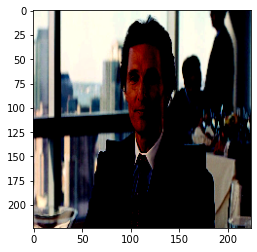

In [28]:
plt.imshow (X_test[3])

Show original mask for test image

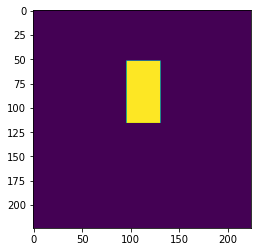

In [30]:
plt.imshow (y_test[3])

Predict the mask on the test image

1/1 [==============================] - 10s 10s/step


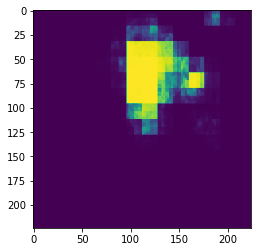

In [31]:
y_pred = model.predict(X_test)
plt.imshow (y_pred[3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


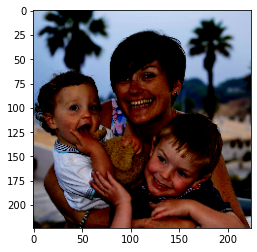

In [45]:
plt.imshow (X_test[0])

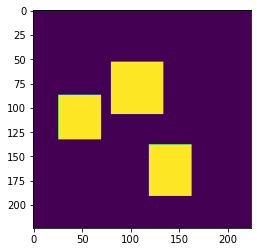

In [46]:
plt.imshow (y_test[0])

1/1 [==============================] - 2s 2s/step


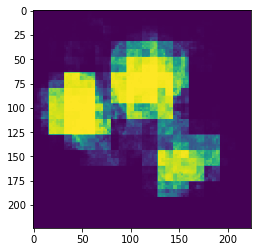

In [47]:
y_pred = model.predict(X_test)
plt.imshow (y_pred[0])

# Conclusion
Project was all about how we can make use of a pretrained MobileNet (Transfer Learning) and on top of it add all the UNET layers to train, fit and evaluate model with an objective to predict the boundaries(mask) around the face in a given image.

  * Model was complied using binary cross entropy as loss, adam optimizer and dice coefficient as metrics.
  * Model checkpoint, early stopping and learning rate reducers were used as callbacks.
  * Data was split into train and validation using 90/10 ratio. Best loss I got is 0.7925 and dice_coefficient of 0.6016 on the training data with just 15 epochs.
  * Model weights for this were used and then used to predict on validation data to get mask.
  * Further checked on sample image and imposed mask on the image.
  * As seen in the above images, it can be seen that model does a very good job in predicting the masks.

![alt text](https://drive.google.com/uc?export=view&id=1UXScsVx_Wni_JuDdB8LeTnM6jsPfIwkW)